In [1]:
import datetime
import pyaurorax

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools
at.set_theme("dark")

# Create THEMIS keogram

Keograms are a useful data product that can be generated from ASI image data. A keogram is created by stacking slices of the middle column (a N-S slice for the orientation of the UCalgary imagers) of pixels from ASI images over a period of time. 

Below, we'll work through the creation of a 1 hour keogram created from THEMIS data.

In [2]:
# download an hour of THEMIS ASI data
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2021, 11, 4, 9, 0)
end_dt = datetime.datetime(2021, 11, 4, 9, 59)
site_uid = "atha"
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

In [3]:
# read in the hour of data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)

In [4]:
# scale all the images
#
# NOTE: you can scale all images or just one image
images_scaled = at.scale_intensity(data.data, min=1000, max=10000)

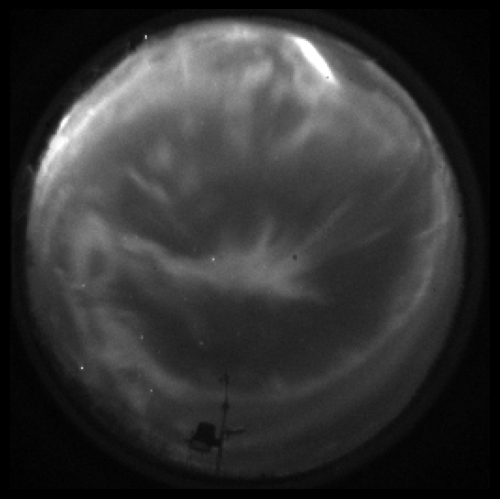

In [5]:
# show the first frame to evaluate our scaling
at.display(images_scaled[:, :, 0], cmap="gray")

## Generate keogram

Now that we have our data how we want it, let's create a basic CCD-space keogram.

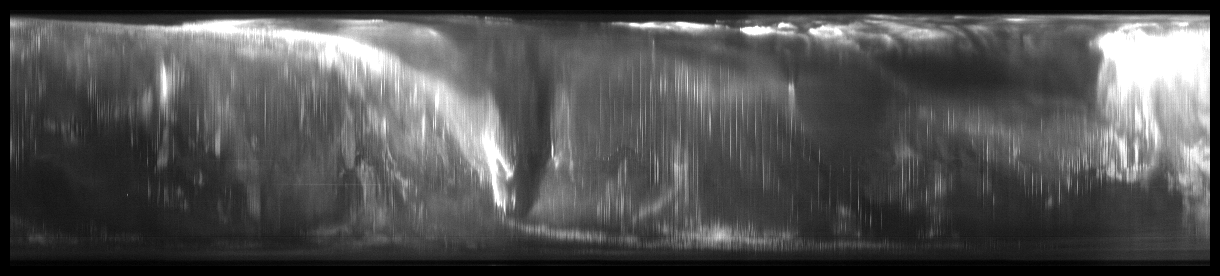

In [6]:
# create the keogram
keogram = at.keogram.create(images_scaled, data.timestamp)

# use the simple 'display' function to show it
at.display(keogram.data, cmap="gray", figsize=(12, 4))

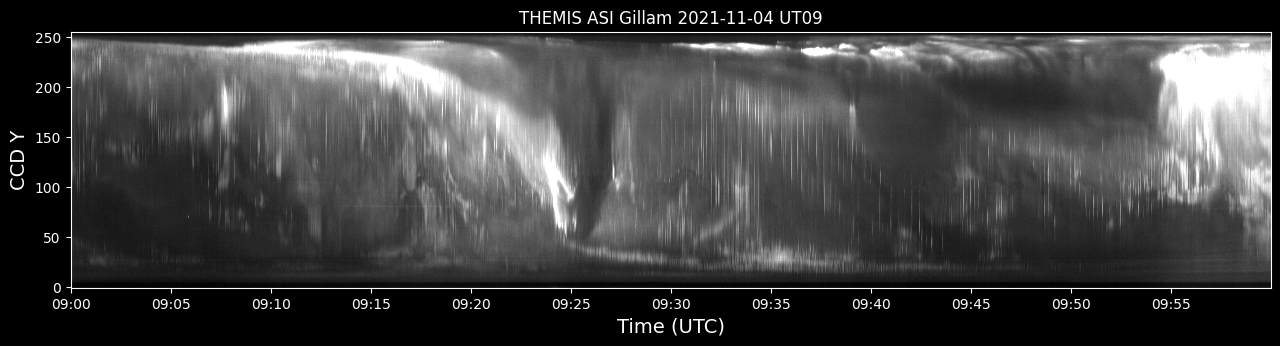

In [7]:
# use the keogram's 'plot' function instead to show the keogram
keogram.plot(
    title="THEMIS ASI Gillam %s" % (start_dt.strftime("%Y-%m-%d UT%H")),
    figsize=(12, 4),
    cmap="gray",
)

## Reference in geographic coordinates

For each camera, the UCalgary maintains a geospatial calibration dataset that maps pixel coordinates (detector X and Y) to local observer and geodetic coordinates (at altitudes of interest). We refer to this calibration as a 'skymap'. The skymaps may change due to the freeze-thaw cycle and changes in the building, or when the instrument is serviced. A skymap is valid for a range of dates. The metadata contained in a file includes the start and end dates of the period of its validity.

Be sure you choose the correct skymap for your data timeframe. The `download_best_skymap()` function is there to help you, but for maximum flexibility you can download a range of skymap files and use whichever you prefer. All skymaps can be viewed by looking at the data tree for the imager you are using (see https://data.phys.ucalgary.ca/), or using the PyAuroraX `get_urls()` or `download()` functions. If you believe the geospatial calibration may be incorrect, please contact the UCalgary team.

For more on the skymap files, please see [the skymap file description document](https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf).

In [8]:
# download skymap file
r = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, start_dt)
skymap_data = aurorax.data.ucalgary.read(r.dataset, r.filenames).data[0]

In [9]:
# set the geographic latitudes for the keogram
keogram.set_geographic_latitudes(skymap_data)

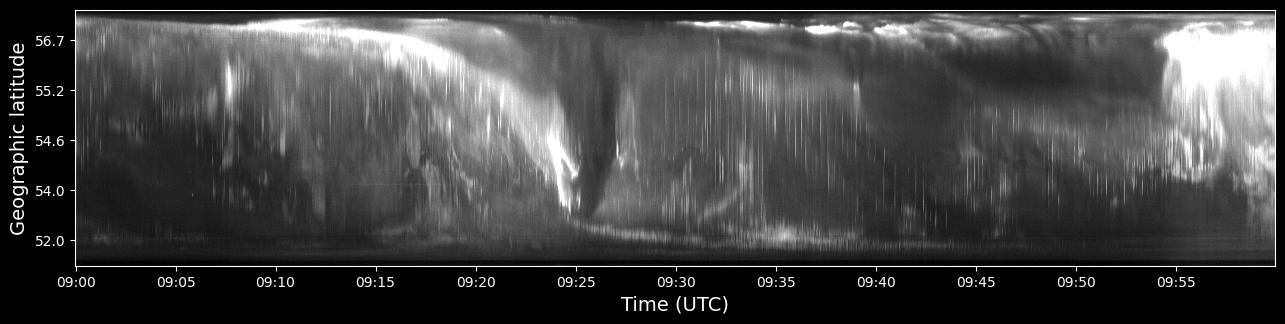

In [10]:
# plot the keogram
keogram.plot(figsize=(12, 4), cmap="gray", y_type="geo")

## Reference in magnetic coordinates

Leveraging AACGM, we can also display the keogram using magnetic latitudes.

In [11]:
# set the magnetic latitudes for the keogram
keogram.set_magnetic_latitudes(skymap_data, start_dt)

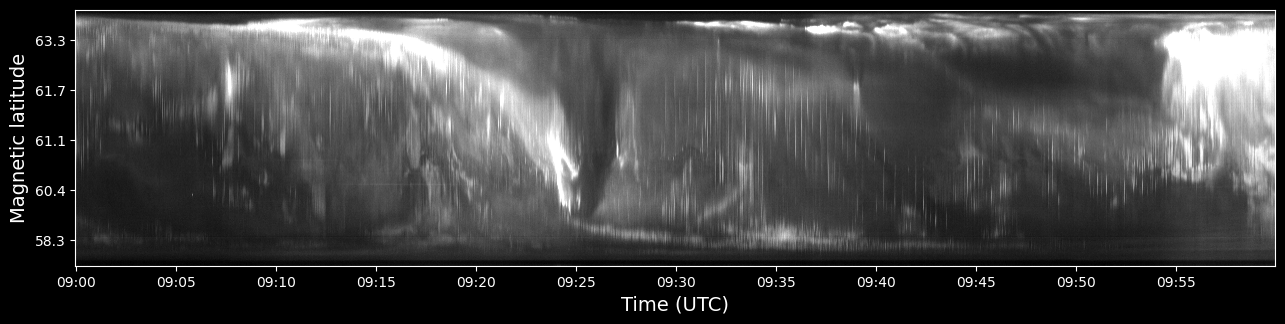

In [12]:
# plot the keogram
keogram.plot(figsize=(12, 4), cmap="gray", y_type="mag")

## Dealing with missing data

When a keogram is created using `aurorax.tools.keogram.create()`, it will only include timestamps for which data exists. Sometimes you may want to indicate missing data in the keogram, and this can be done using a Keogram object's `inject_nans()` method.

As an example, let's create a keogram for some data from a different date that we know has some missing data. We will also change our plotting theme to light mode, so that missing data will appear white in the keogram. This will make is easier to distinguish between data that is actually missing and data that is just dark/black.

In [13]:
# Change to light theme for indicating missing data
at.set_theme("light")

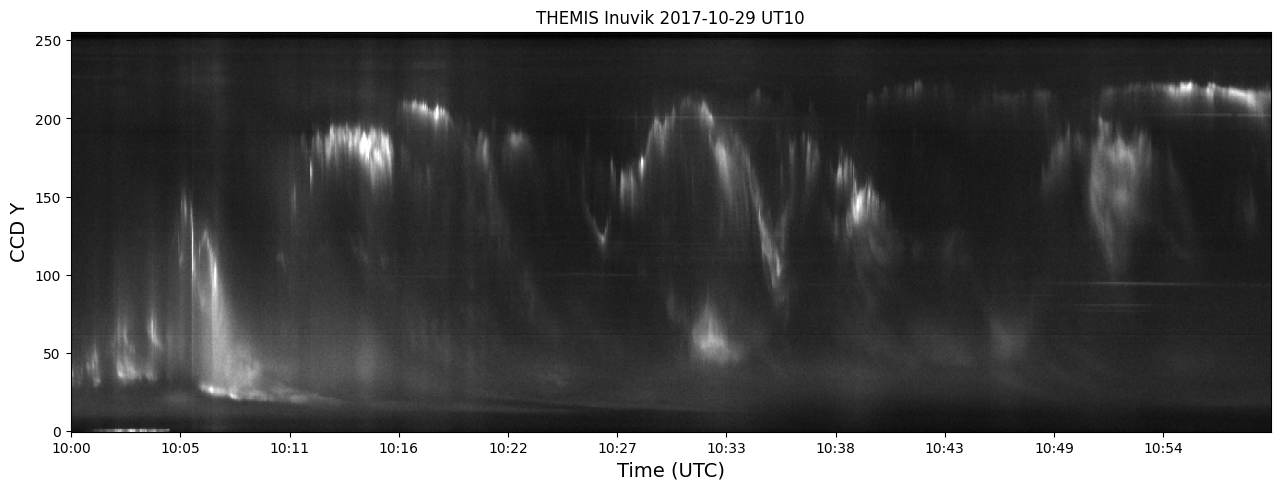

In [14]:
# Now, repeating the above steps to create another keogram for a different time range

# Grab another hour of THEMIS data
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2017, 10, 29, 10, 0)
end_dt = datetime.datetime(2017, 10, 29, 10, 59)
site_uid = "inuv"
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

# Read in the data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)

# Scale the data
images_scaled = at.scale_intensity(data.data, min=1000, max=6000)

# Create the keogram
keogram = at.keogram.create(images_scaled, data.timestamp)

# Plot the keogram
keogram.plot(title="THEMIS Inuvik %s" % (start_dt.strftime("%Y-%m-%d UT%H")), figsize=(12, 4), cmap="gray", aspect="auto",)

Let's inspect the shape. For an hour of THEMIS data, which has 3 s cadence and thus 20 frames per minute, we would expect 20 $\times$ 60 = 1200 frames of data.

In [15]:
print(keogram.data.shape)

(256, 1099)


You'll notice that the keogram only has 1099 pixels in the x-direction, indicating that there is some missing data. To visualize this, let's call the `inject_nans()` method.

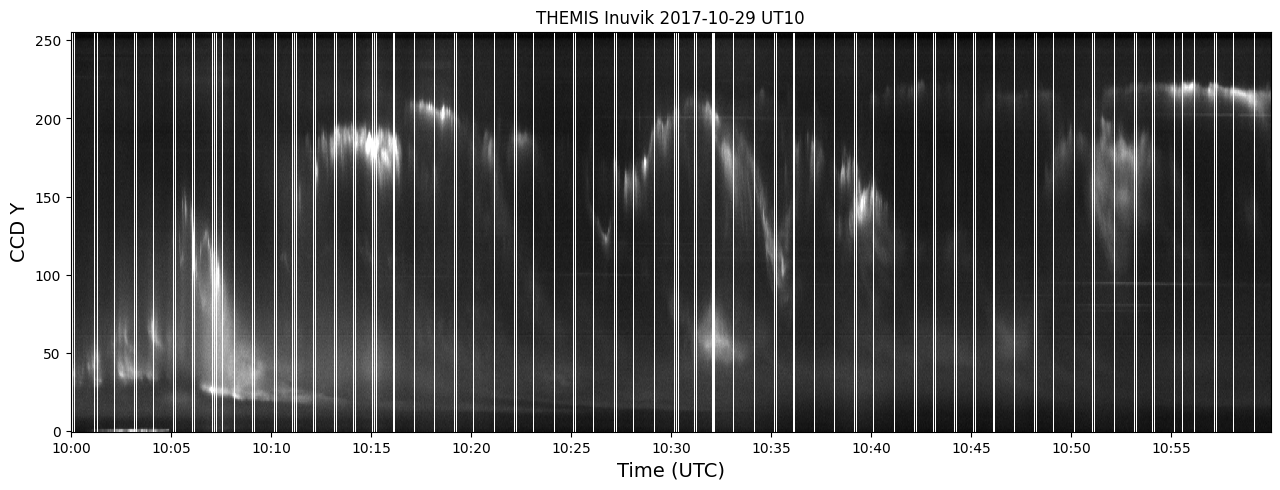

(256, 1200)


In [16]:
# Fill missing data columns with NaNs
keogram.inject_nans()

# Plot the updated keogram
keogram.plot(title="THEMIS Inuvik %s" % (start_dt.strftime("%Y-%m-%d UT%H")), figsize=(12, 4), cmap="gray", aspect="auto")

# Print the shape of the updated keogram
print(keogram.data.shape)

Now, the keogram is the expected size, and indicates where data is missing. Using the `inject_nans()` function is a good way to check for missing data. In cases where there is no data missing, it will have no effect on the keogram.